# Network of Grooming Partners

The plot that will be reproduced in this example is a network plot of grooming partners in a baboon group from Tung et al. (2015) in eLife (doi: [10.7554/eLife.05224](http://dx.doi.org/10.7554/eLife.05224)). This plot from the paper shows the grooming partners within "Mica's" group of Amboseli baboons from August 2011 to August 2012.

![](images/groomnetwork_plot.png)

The data underlying this plot are archived at DataDryad (doi: [10.5061/dryad.8gp03.2](http://dx.doi.org/10.5061/dryad.8gp03.2)) and are available in my bioanth datasets repository.

Social networks have always been important in primatological research, but it seems to me that only recently have the statistical and computational tools for network analysis begun to be used more in biological anthropology.

## Caveats

The available tools for network analysis in R are mature, but some of the plotting tools are less so, especially those based on ggplot2. In addition, the layout in the plot above is, as far as I can tell, unachievable in R. I will provide examples of a circular layout that is similar in some ways and explore some other layout options that might actually provide a clearer view of the grooming relationships than the original plot.

## Preliminaries

As always, I change the R option for importing strings (I find that the default convert to factor causes more problems than it solves).

In [1]:
options(stringsAsFactors=F)

Next, import the data. The data are a matrix of normalized grooming relationship strength, with a value of 1 for the strongest grooming relationship and 0 for no grooming relationship.

In [3]:
dataurl = "https://raw.githubusercontent.com/ryanraaum/bioanth-datasets/master/raw/networkgroom.csv"
dmatrix = as.matrix(read.csv(url(dataurl), row.names=1))

# look at a part of this matrix to see what it looks like
dmatrix[10:15, 10:15]

,F10,F11,F12,F13,M12,M14
F10,0.00000000,0.19512195,0.39024390,0.09756098,0.02439024,0.00000000
F11,0.19512195,0.00000000,0.04878049,0.02439024,0.00000000,0.26829268
F12,0.39024390,0.04878049,0.00000000,0.02439024,0.02439024,0.00000000
F13,0.09756098,0.02439024,0.02439024,0.00000000,0.02439024,0.07317073
M12,0.02439024,0.00000000,0.02439024,0.02439024,0.00000000,0.00000000
M14,0.00000000,0.26829268,0.00000000,0.07317073,0.00000000,0.00000000


The original plot has the lines ('edges') connecting individuals ('nodes' or 'vertexes') colored differently according to grooming relationship strength, so I will create a function to assign these colors.

In [4]:
ecolor_map = function(x) {
    if (x < 0.1) {return("#FDEBDD")}
    else if (x >= 0.1 & x < 0.2) {return("#FBBD84")}
    else if (x >= 0.2 & x < 0.3) {return("#FC8B3B")}
    return("#D74701")
}

## Plotting approaches

There are no network plotting tools that are a built in part of base R, ggplot2, or lattice. As far as I can tell, there are no network plotting tools in lattice at all.

In addition, there are no standard network data structures in base R. There are two commonly used packages that provide both network data structures and plotting tools (using base R). These are `igraph` and the `statnet` packages. Here, I will give examples using both of these.

## igraph

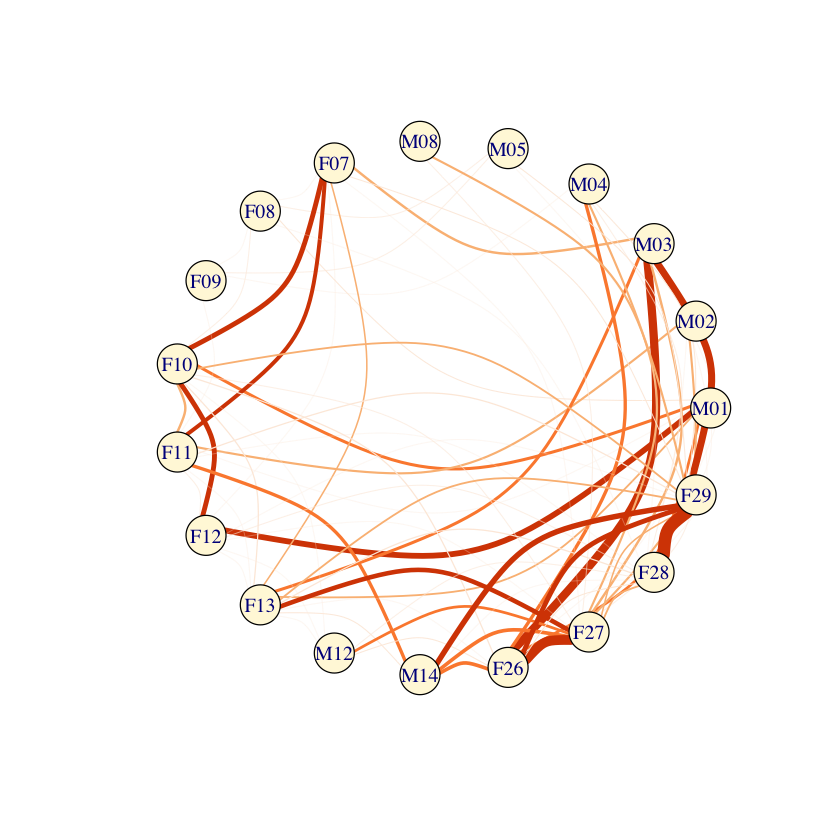

In [29]:
library(igraph)

# the matrix of grooming pairwise grooming relationship strength is
# a type of "adjacency matrix" that can easily be turned into a 
# network ('graph') object
g = graph.adjacency(dmatrix, 
                    # undirected = connections are symmetrical
                    mode="undirected", 
                    # store the matrix values > 0 as edge weights
                    weighted=TRUE)

# get the colors for the edges using the function defined earlier
ecolors = sapply(E(g)$weight, ecolor_map)

# plot in circular layout (no available layout in igraph like the original)
plot(g, layout=layout_in_circle, 
        # scale edge width to grooming relationship strength
        edge.width=10*E(g)$weight, 
        # curved lines
        edge.curved=T,
        # color the edges
        edge.color=ecolors,
        # change the background color of the nodes
        vertex.color='cornsilk')

An alternative layout that might provide a clearer visualization is a force-directed layout using the Fruchterman–Reingold algorithm. This is one of a class of algorithms that model the network with mutually repellent nodes that dynamically seek a configuration of lowest energy. As such, the appearance is dependent on the specific starting conditions and will look different every time unless you deliberately set the random number generator seed before plotting.

We can also use the grooming strengths as `weights` for the layout, with larger weights making longer edges between nodes.

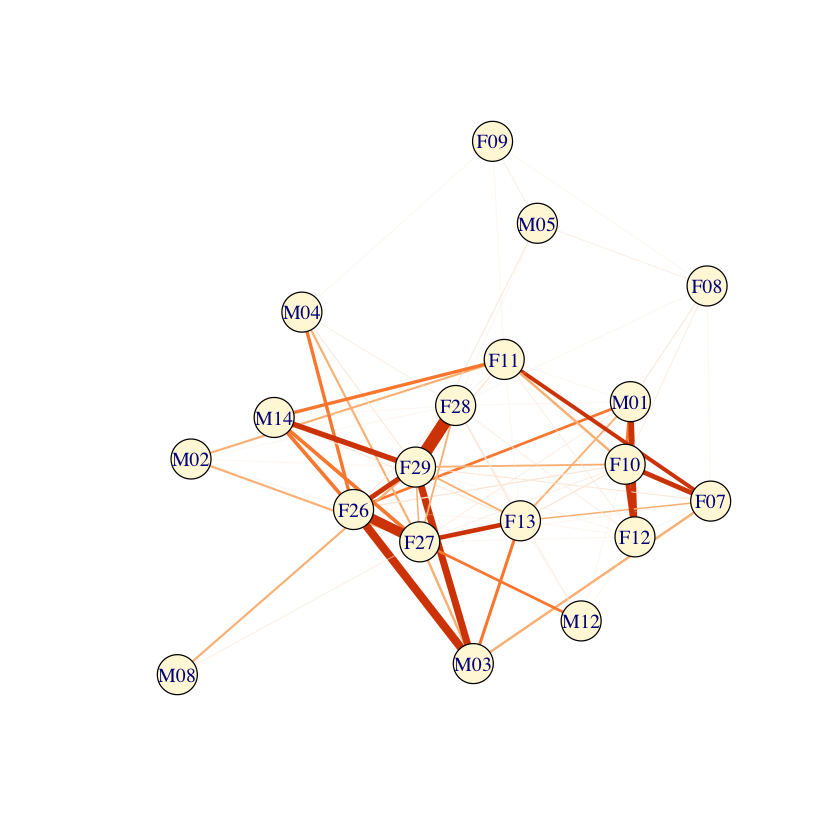

In [32]:
# I tried different seeds until I got a layout that I liked
set.seed(8)

# use a weighted Fruchterman–Reingold layout
# since larger weights push nodes farther apart,
# invert the grooming strength values so lesser relationships
# have larger weights
plot(g, layout=layout_with_fr(g, weight=1/E(g)$weight),  
        # everything else is the same as above
        edge.width=10*E(g)$weight, 
        edge.curved=F, 
        edge.color=ecolors,
        vertex.color='cornsilk')

## statnet

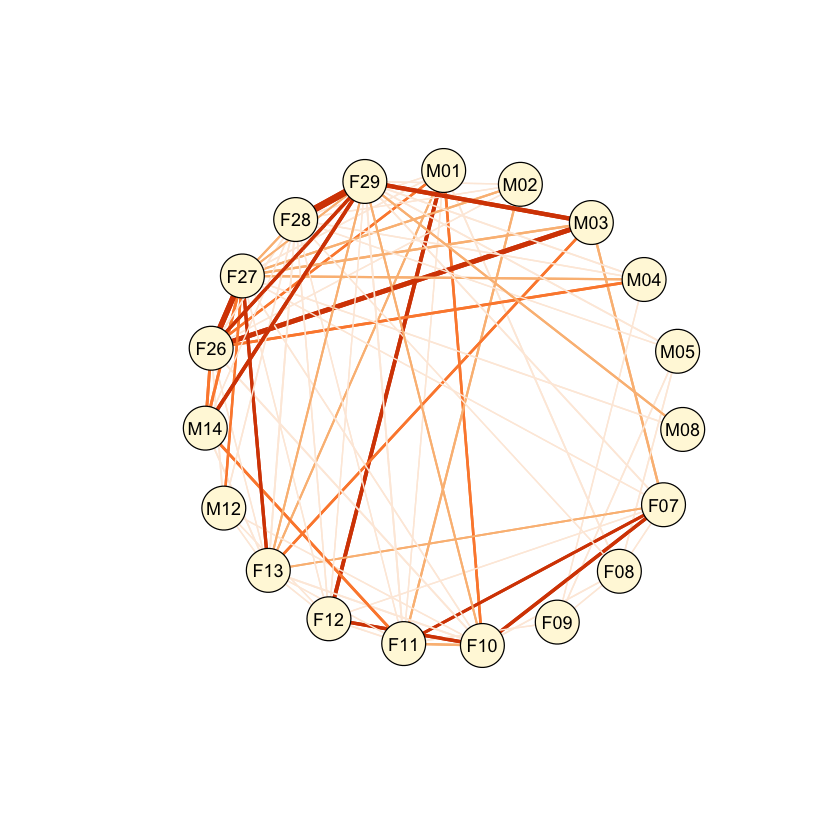

In [59]:
# both of these are part of the statnet distribution
library(network) # for the network structure
library(sna) # for the plotting function

# create the network object
net = network(dmatrix, 
              matrix.type="adjacency", 
              # network is undirected; connections are symmetrical
              directed=F, 
              # need the next two lines to store the grooming matrix
              # relationship strength values into the network object 
              # and call this variable "groom"
              ignore.eval=FALSE,
              names.eval="groom")

# get the colors for the edges using the function defined earlier
ecolors = sapply(net%e%'groom', ecolor_map)

gplot(net, 
      # "graph" mode is for undirected networks
      gmode="graph", 
      # set the layout
      mode="circle", 
      # make the nodes a little bigger and change background color
      vertex.cex=2,
      vertex.col='cornsilk',
      # label the nodes
      label=net %v% 'vertex.names',
      # put the label in the center of the node 
      label.pos=5,
      # make the label a little smaller than default
      label.cex=0.9,
      # scale the edge widths to the groom relationship strength
      edge.lwd=net%e%'groom'*5,
      # set the edge colors
      edge.col=ecolors,
      # curved edges only work properly for directed graphs;
      # for undirected graphs, two edges are displayed between each
      # pair of connected nodes.
      usecurve=F)

## ggplot2 network plotting

At the moment, there are at least three ggplot2 based network plotting packages: **ggnet**, **ggnetwork**, and **ggraph**. Of these, **ggnet** and **ggnetwork** are reasonably mature, but **ggraph** is still bleeding-edge. 

Whereas the earlier solutions provided *both* network structures and plotting facilities for those network structures, the ggplot2 methods don't reinvent the network structures and use either `statnet` or `igraph` structures or both.

### ggnet

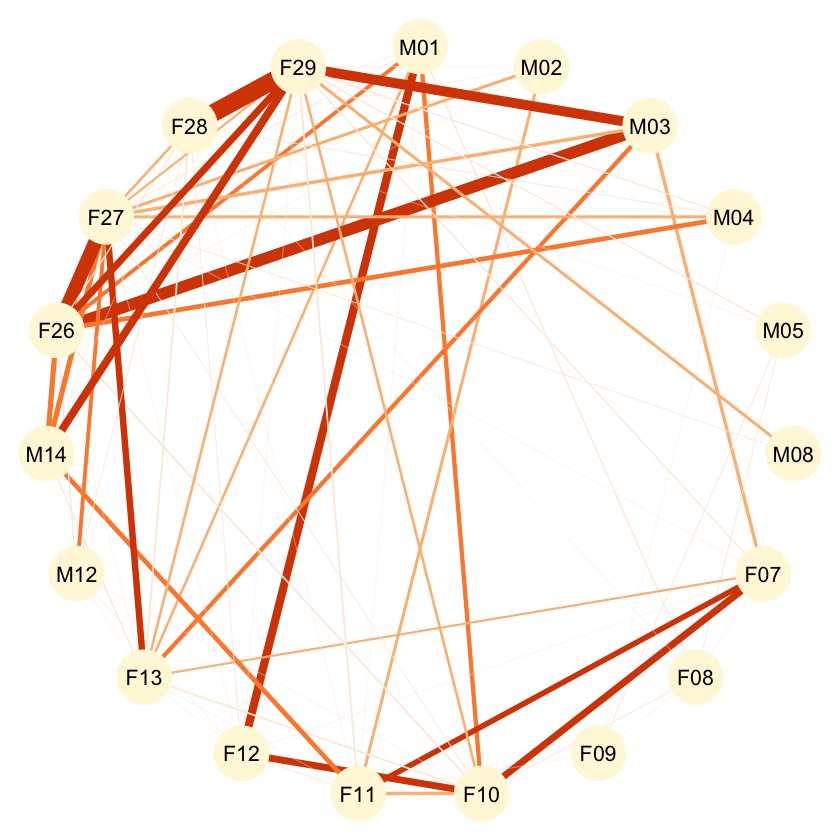

In [14]:
library(network) # for the network object
library(ggplot2) 
library(GGally)  # for ggnet2 plotting function

# see statnet comments above for network object creation
net = network(dmatrix, matrix.type="adjacency", 
              directed=F, ignore.eval=FALSE, names.eval="groom")

# get the colors for the edges using the function defined earlier
ecolors = sapply(net%e%'groom', ecolor_map)

# plot the network
ggnet2(net, 
       # layout
       mode="circle",
       # node color
       # (cannot figure out a simple way to get a black border on the node)
       color="cornsilk",
       # set node size
       size=15,
       # set node labels
       label='vertex.names',
       # set edge colors
       edge.color=ecolors,
       # scale edge size to grooming relationship strength
       edge.size=net%e%'groom'*5)

### ggnetwork

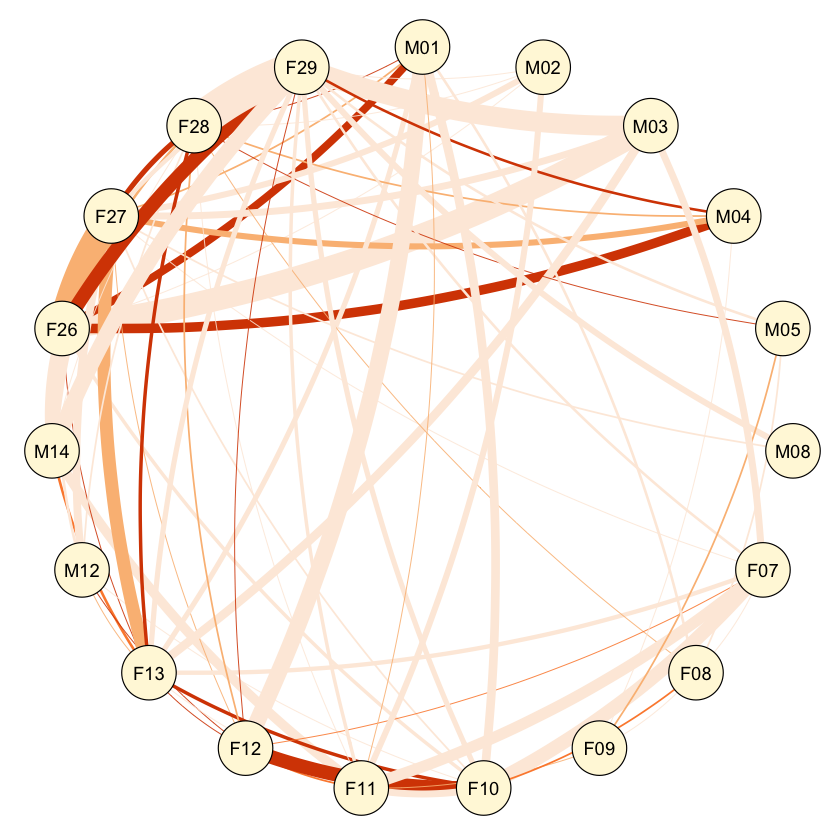

In [94]:
library(ggnetwork) 
library(network) # for network structure

# see statnet comments above for network object creation
net = network(dmatrix, matrix.type="adjacency", 
              directed=F, ignore.eval=FALSE, names.eval="groom")

net %e% "ecolor" = sapply(net %e% 'groom', ecolor_map)

# plot the network
ggplot(ggnetwork(net, layout="circle"), aes(x=x, y=y, xend=xend, yend=yend)) +
    geom_edges(aes(size=I(groom)*10, color=I(ecolor)), curvature=0.1) +
    geom_nodes(shape=21, color="black", fill="cornsilk", size=15) +
    geom_nodetext(label=V(g)$name) +
    theme_blank()

